In [1]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
np.set_printoptions(threshold=50, edgeitems=20)

In [2]:
print(torch.cuda.current_device())
torch.cuda.set_device(1)

0


In [3]:
train = pd.read_csv('./datasets/ihm/train.csv')
test = pd.read_csv('./datasets/ihm/test.csv')
val = pd.read_csv('./datasets/ihm/val.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
val = val.drop('Unnamed: 0', axis=1)

In [4]:
print(len(train[train['Mortality'] == 1]))
print(len(train[train['Mortality'] == 0]))

180592
1014121


In [5]:
train_size = len(train)
train = train.append(val)


print(train_size)
print(len(train))
val_idx = list(range(train_size, len(train)))

1194713
1458046


In [6]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response','Episode' ]


for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate', 3), ('Glascow coma scale eye opening', 6), ('Glascow coma scale motor response', 7), ('Glascow coma scale total', 14), ('Glascow coma scale verbal response', 6), ('Episode', 17904)]


In [7]:
df, y, nas, mapper = proc_df(train, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test, 'Mortality', do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=256,
                                       test_df=df_test)

In [8]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [250,250], [0,0,0], y_range=[0.0,1.0])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 38%|███▊      | 1778/4667 [00:16<00:26, 107.03it/s, loss=9.37e-05]

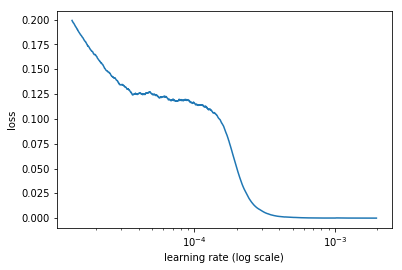

In [9]:
m.lr_find()
m.sched.plot(100)


In [12]:
lr = 0.001


def roc_auc(preds, y):
    return metrics.roc_auc_score(y.cpu().numpy(), preds.cpu().numpy())

def accuracy1(preds, targs):
    #print ('preds: {}, {}'.format(preds.ceil() ,type(preds)))
    #print ('targs: {}, {}'.format(targs.ceil() ,type(targs)))
    return (preds.long()==targs.long()).float().mean()


In [14]:


m.fit(lr, 3, metrics=[accuracy1], cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

  2%|▏         | 91/4667 [00:00<00:46, 99.35it/s, loss=7.11e-13] 

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/andreas/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/andreas/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/andreas/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy1                         
    0      1e-06      0.229718   0.851873  
    1      0.0        0.229467   0.851873                          
    2      0.0        0.228312   0.851873                          
    3      5e-06      0.22825    0.851873                          
    4      0.0        0.227657   0.851873                          
    5      0.0        0.227563   0.851873                          



[0.22756301, 0.8518731382286664]

In [ ]:
def balance_dataset(df):
    split_set = []
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
    num_survived = len(df.loc[df['Mortality'] < 1])
    num_died = len(df) - num_survived
    counter = 0
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died < num_survived:
            split_set.append(patient)
            counter = counter +1
            num_died = num_died +1
    print(num_died, num_survived)
    complete_data =  pd.DataFrame(columns=df[0].columns)
    for patient in split_set:
        complete_data = pd.concat([complete_data,patient])
    return complete_data




train_balanced = balance_dataset(train)

In [ ]:
len(train_balanced)